# Areal Project

Challenge solved by:
- Phan Anh Vu: (phanav)
- Mohamed Salem Messoud: (mdsalem17)


<div>
    <h2>Introduction </h2>
     <br>
Aerial imagery has been a primary source of geographic data for quite a long time. With technology progress, aerial imagery became really practical for remote sensing : the science of obtaining information about an object, area or phenomenon.
Nowadays, there are many uses of image recognition spanning from robotics/drone vision to autonomous driving vehicules or face detection.
<br>
In this challenge, we will use pre-processed data, coming from landscape images. The goal is to learn to differentiate common and uncommon landscapes such as a beach, a lake or a meadow.
    Data comes from part of the data set (NWPU-RESISC45) originally used in <a href="https://arxiv.org/pdf/1703.00121.pdf?fbclid=IwAR16qo-EX_Z05ZpxvWG8F-oBU0SlnY-3BPCWBVVOGPyJcVy7BBqCKjnsvJo">Remote Sensing Image Scene Classification</a>. This data set contains 45 categories while we only kept 13 out of them.

References and credits: 
Yuliya Tarabalka, Guillaume Charpiat, Nicolas Girard for the data sets presentation.<br>
Gong Cheng, Junwei Han, and Xiaoqiang Lu, for the original article on the chosen data set.
</div>

### Requirements and Link Editions

The next cell will install all the required dependencies on your computer. You should consider replacing pip with pip3 if pip is related to python2.7 on your computer, or comment it if you already have the dependencies/are running in the docker of the challenge (runnable with the name areal/codalab:pytorch if you know how to run a docker).

In [1]:
#Reminder: You should install FastAI, if you don't have it
#!pip install fastai==1.0.61

In [2]:
#!pip install --user -r requirements.txt

In [3]:
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import os
import sys
from pathlib import Path
import shutil

In [4]:
root_dir = Path("..")

In [5]:
str_ = str(os.getcwd())
print(str_)
starting_dir = Path(str_)
print(root_dir)
starting_dir = root_dir.joinpath("starting_kit")
print(starting_dir)
if str_.endswith('starting_kit'):
    str_ = str_[:-len('starting_kit')]
print(str_)

/Users/md_76s/Desktop/Files/starting_kit
..
../starting_kit
/Users/md_76s/Desktop/Files/


In [6]:
#root_dir = Path("/content/drive/MyDrive/Education/Master Informatique IA Computer Science AI Paris Saclay/AI/OPT9 Datacamp/TP5 Aerial")
root_dir = Path(str_)

starting_dir = root_dir.joinpath("starting_kit")
os.chdir(starting_dir)

print(os.listdir(root_dir))
print(os.listdir(starting_dir))

['.DS_Store', 'starting_kit.zip', 'readme.md', 'public_data', 'starting_kit', 'image_data', 'tf_image_data']
['scoring_output', 'tensorflow_model.ipynb', '.DS_Store', 'requirements.txt', 'sample_result_submissionAreal_valid.predict', 'sample_result_submissionAreal_test.predict', 'fastai_model.ipynb', 'sample_code_submission', 'sample_result_submission', 'fastai_model-Copy1.ipynb', 'models', 'README.md', 'sample_data', 'logo.jpg', 'submissions', 'sample_result_submissionAreal_train.predict', '.ipynb_checkpoints', 'scoring_program', 'BasicCNN.ipynb', 'ingestion_program']


In [7]:
model_dir = 'sample_code_submission'
result_dir = 'sample_result_submission/'
problem_dir = 'ingestion_program/'
score_dir = 'scoring_program/'

In [8]:
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);

Go through the challenge website and watch the trailer video.

#### Question 1: Briefly explain the problem.

*The task is to classify the images into one of 13 different categories each by assigning the correct tag. The categories are:
Beach, Chaparral, Cloud, Desert, Forest, Island, Lake, Meadow, Mountain, River, Sea Ice, Snowberg, Wetland.*

#### Question 2: What is the scoring metric used to evaluate submissions?

The scoring metric used is the basic Accuracy given by the formula below. Accuracy is the proportion of true predictions among the total number of cases examined.


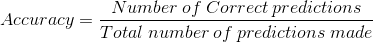

<div>
    <h1> 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
</div>

In [9]:
sample_data_dir = starting_dir.joinpath("sample_data")
public_data_dir = root_dir.joinpath("public_data")
data_name = 'Areal'

In [10]:
from ingestion_program import data_converter

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
Files being big, your computer needs to have enough space available in your RAM. It should take about 3-4GB while loading and 1.5GB in the end.

In [11]:
from ingestion_program.data_io import read_as_df
data = read_as_df(str(sample_data_dir)  + '/' + data_name)

Reading /Users/md_76s/Desktop/Files/starting_kit/sample_data/Areal_train from AutoML format
Number of examples = 65
Number of features = 49152
        Class
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland
Number of classes = 13


In [12]:
data.head()

pixel_1_1_R  pixel_1_1_G  pixel_1_1_B  pixel_1_2_R  pixel_1_2_G  \
0          145          145          121          113          113   
1          193          168          138          191          166   
2           83           86           67           65           68   
3           16           52           48           15           51   
4           60           79           47           80           99   

   pixel_1_2_B  pixel_1_3_R  pixel_1_3_G  pixel_1_3_B  pixel_1_4_R  ...  \
0           89           73           75           53           65  ...   
1          136          201          176          146          194  ...   
2           49           73           78           58           78  ...   
3           47           15           52           45           15  ...   
4           67           62           81           51           45  ...   

   pixel_128_126_R  pixel_128_126_G  pixel_128_126_B  pixel_128_127_R  \
0              191              164              134              196   
1              196              171              140              197   
2              115              110               91              115   
3               65               83               61               58   
4              182              197              202              121   

   pixel_128_127_G  pixel_128_127_B  pixel_128_128_R  pixel_128_128_G  \
0              169              139              202              175   
1              172              141              201              176   
2              107               88              141              133   
3               75               56               68               85   
4              135              144              120              137   

   pixel_128_128_B    target  
0              145    desert  
1              145    desert  
2              114    meadow  
3               66     river  
4              147  mountain  

[5 rows x 49153 columns]

In [13]:
data.describe()

pixel_1_1_R  pixel_1_1_G  pixel_1_1_B  pixel_1_2_R  pixel_1_2_G  \
count    65.000000    65.000000    65.000000    65.000000    65.000000   
mean     96.630769   102.030769    93.676923    97.230769   102.661538   
std      63.041794    52.057051    52.828765    64.983356    53.971427   
min      13.000000    14.000000    14.000000     6.000000    13.000000   
25%      53.000000    63.000000    52.000000    44.000000    64.000000   
50%      82.000000    88.000000    85.000000    80.000000    96.000000   
75%     141.000000   137.000000   135.000000   139.000000   145.000000   
max     239.000000   240.000000   245.000000   237.000000   239.000000   

       pixel_1_2_B  pixel_1_3_R  pixel_1_3_G  pixel_1_3_B  pixel_1_4_R  ...  \
count    65.000000    65.000000    65.000000    65.000000    65.000000  ...   
mean     94.323077    94.353846    99.584615    91.230769    93.076923  ...   
std      54.017679    63.980815    53.380091    53.738594    64.282168  ...   
min      12.000000     9.000000    13.000000    11.000000    11.000000  ...   
25%      49.000000    46.000000    60.000000    48.000000    45.000000  ...   
50%      88.000000    74.000000    87.000000    84.000000    77.000000  ...   
75%     136.000000   136.000000   140.000000   136.000000   136.000000  ...   
max     242.000000   239.000000   238.000000   243.000000   240.000000  ...   

       pixel_128_125_B  pixel_128_126_R  pixel_128_126_G  pixel_128_126_B  \
count        65.000000        65.000000        65.000000        65.000000   
mean         98.015385        99.307692       103.800000        94.523077   
std          58.560463        63.085241        54.084194        55.020765   
min          12.000000        10.000000        15.000000         9.000000   
25%          60.000000        55.000000        63.000000        58.000000   
50%          90.000000        73.000000        90.000000        74.000000   
75%         121.000000       152.000000       141.000000       128.000000   
max         255.000000       240.000000       249.000000       254.000000   

       pixel_128_127_R  pixel_128_127_G  pixel_128_127_B  pixel_128_128_R  \
count        65.000000        65.000000        65.000000        65.000000   
mean         97.369231       101.738462        93.076923        95.800000   
std          60.896575        50.817467        51.335389        55.726509   
min          14.000000        19.000000        14.000000        17.000000   
25%          53.000000        60.000000        56.000000        53.000000   
50%          74.000000        97.000000        86.000000        76.000000   
75%         138.000000       144.000000       130.000000       135.000000   
max         235.000000       245.000000       254.000000       232.000000   

       pixel_128_128_G  pixel_128_128_B  
count        65.000000        65.000000  
mean        100.323077        91.600000  
std          43.865956        43.464713  
min          22.000000        18.000000  
25%          64.000000        55.000000  
50%          96.000000        92.000000  
75%         137.000000       132.000000  
max         212.000000       218.000000  

[8 rows x 49152 columns]

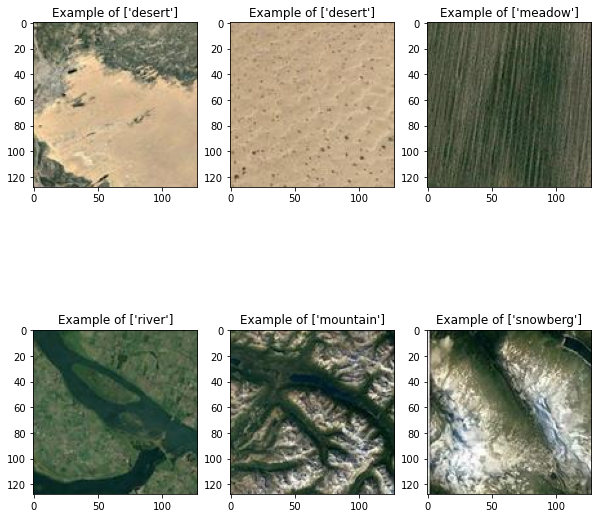

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

num_toshow = 6
fig, _axs = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
fig.subplots_adjust(hspace=0.3)
axs = _axs.flatten()

for i in range(num_toshow):
    img = data.iloc[i].values[:-1].reshape(128,128,3)
    label = data.iloc[i].values[-1:]
    axs[i].set_title('Example of {}'.format(label))
    axs[i].imshow(img.astype(float) / 255)

plt.show()

In [14]:
print(data.iloc[:, -1:])
X = data.iloc[:, :-1]
y = data.iloc[:, -1:]

      target
0     desert
1     desert
2     meadow
3      river
4   mountain
..       ...
60    island
61    island
62      lake
63     beach
64    forest

[65 rows x 1 columns]


In [15]:
print(X.shape, y.shape)

(65, 49152) (65, 1)


# 2 : Building a predictive model

<h2 style="color:red " >Warning</h2>

<p style="font-style:italic"> In case you want to load the full data </p> 
This time, also, still make sure that your RAM has at least 2-3GB available.

In [16]:
from ingestion_program.data_manager import DataManager
D = DataManager(data_name, str(public_data_dir), replace_missing=False, verbose=True)
print(D)

Info file found : /Users/md_76s/Desktop/Files/public_data/Areal_public.info
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_feat.type
[+] Success in  0.00 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_train.data
[+] Success in 176.89 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_train.solution
[+] Success in  0.03 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_valid.data
[+] Success in 61.76 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_valid.solution
[+] Success in  0.00 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_test.data
[+] Success in 43.20 sec
========= Reading /Users/md_76s/Desktop/Files/public_data/Areal_test.solution
[+] Success in  0.00 sec
DataManager : Areal
info:
	usage = Sample dataset Areal data
	name = areal
	task = multiclass.classification
	target_type = Categorical
	feat_type = Numerical
	metric = accuracy
	time_budget = 12000
	feat_num = 491

In [17]:
X_train = D.data['X_train']
Y_train = D.data['Y_train']

In [18]:
print(X_train.shape, Y_train.shape)
print(Y_train[:5])

(5200, 49152) (5200, 1)
[[5]
 [0]
 [0]
 [1]
 [0]]


[0]


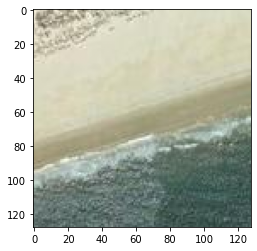

In [19]:
sample_idx = 4
plt.imshow(X_train[sample_idx].reshape(128,128,3).astype(float) / 255)
print(Y_train[sample_idx])

Labels codes: \
0       beach
1   chaparral
2       cloud
3      desert
4      forest
5      island
6        lake
7      meadow
8    mountain
9       river
10        sea
11   snowberg
12    wetland

In [20]:
label_code = 'beach chaparral cloud desert forest island lake meadow mountain river sea snowberg wetland'.split(' ')
image_dir = root_dir.joinpath("image_data")
train_image_dir = image_dir.joinpath('train')
valid_image_dir = image_dir.joinpath('valid')
test_image_dir = image_dir.joinpath('test')
models_dir = starting_dir.joinpath("models")


Save the input as image files \
Inefficient, but the easiest way to use the fastai library

In [22]:

def save_train_array_as_image(arrays, labels, output_dir):
  idx = 0
  for array, label in zip(arrays, labels):
    img = array.reshape(128, 128, 3)
    label_idx = label[0]
    plt.imsave(output_dir.joinpath(f"train-label_{label_code[label_idx]}_{label_idx}-index_{idx}.jpg"), img)
    idx+=1
  
if not os.path.exists(train_image_dir):  
  os.makedirs(train_image_dir)
  save_train_array_as_image(X_train, Y_train, train_image_dir)

print(os.listdir(image_dir))


['valid', '.DS_Store', 'test', 'train']


In [23]:
def save_input_array_as_image(title, output_dir, arrays):
  if not os.path.exists(output_dir):  
    os.makedirs(output_dir)
    idx = 0
    for array in arrays:
      img = array.reshape(128, 128, 3)
      plt.imsave(output_dir.joinpath(f"{title}-index_{idx}.jpg"), img)
      idx+=1



In [24]:
save_input_array_as_image('valid', valid_image_dir, D.data['X_valid'])
save_input_array_as_image('test', test_image_dir, D.data['X_test'])

## FastAI Model

Here, we use the fastai v1 library, a wrapper around PyTorch. \
Some parts may appear strange because we need to comply with the library.\
https://fastai1.fast.ai/tutorial.data.html

In [21]:
import fastai.vision as faiv

In [22]:
# retrieve label from file name
def label_func(file_fullpath):
  filepath = str(file_fullpath)
  filename = filepath[filepath.rindex("/") + 1:]
  label = filename[filename.index("label_") + len("label_") : filename.index("-index")]
  return label


In [23]:
# load the data, from the train image folder
# then random split for validation
# label from filename
# apply data augmentation
# set batch sie to 128
# normalize with imagenet stats, because we will use a pretrained Imagenet model later

databunch = (faiv.ImageList.from_folder(train_image_dir)
        .split_by_rand_pct(valid_pct=0.2)          
        .label_from_func(label_func)
        .transform(faiv.get_transforms(flip_vert=True))
        .databunch(bs=128)
        .normalize(faiv.imagenet_stats))


More details about data augmentation: \
https://fastai1.fast.ai/vision.transform.html

In [24]:
print(databunch)
print(len(os.listdir(train_image_dir)))

ImageDataBunch;

Train: LabelList (4160 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
mountain_8,island_5,beach_0,wetland_12,island_5
Path: /Users/md_76s/Desktop/Files/image_data/train;

Valid: LabelList (1040 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
forest_4,cloud_2,snowberg_11,island_5,cloud_2
Path: /Users/md_76s/Desktop/Files/image_data/train;

Test: None
5201


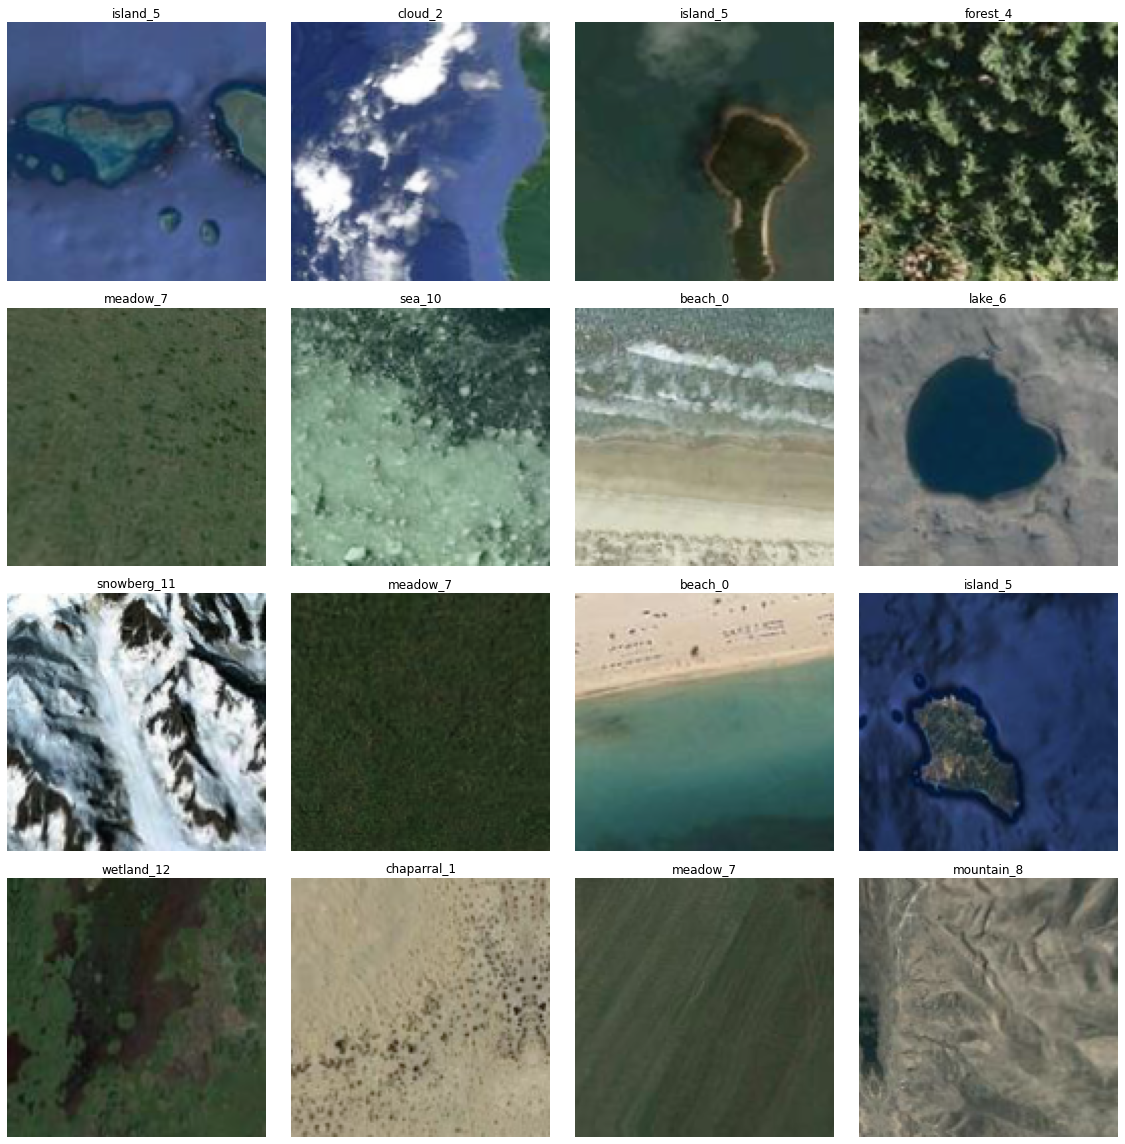

In [25]:
databunch.show_batch(rows=4)

In [26]:
# using a resnet18 pretrained on Imagenet
learner = faiv.cnn_learner(databunch, faiv.models.resnet18, metrics=faiv.accuracy)

To find a suitable learning rate, we run a few batches and observe the loss. \
We want the highest learning rate for faster convergence. \
At the same time, we also need to avoid the danger zone where the loss explodes.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-03
Min loss divided by 10: 2.09E-02


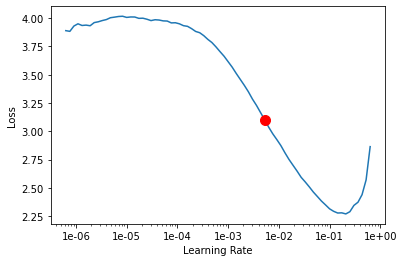

In [31]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [32]:
nepochs = 10
learning_rate = 1e-2
learner.fit_one_cycle(nepochs, learning_rate)

By default, fastai freezes the pretrained component (the convolution component that extracts features). \
The optimizer only updates the weights of the last block (the fully connected layers up to the output).

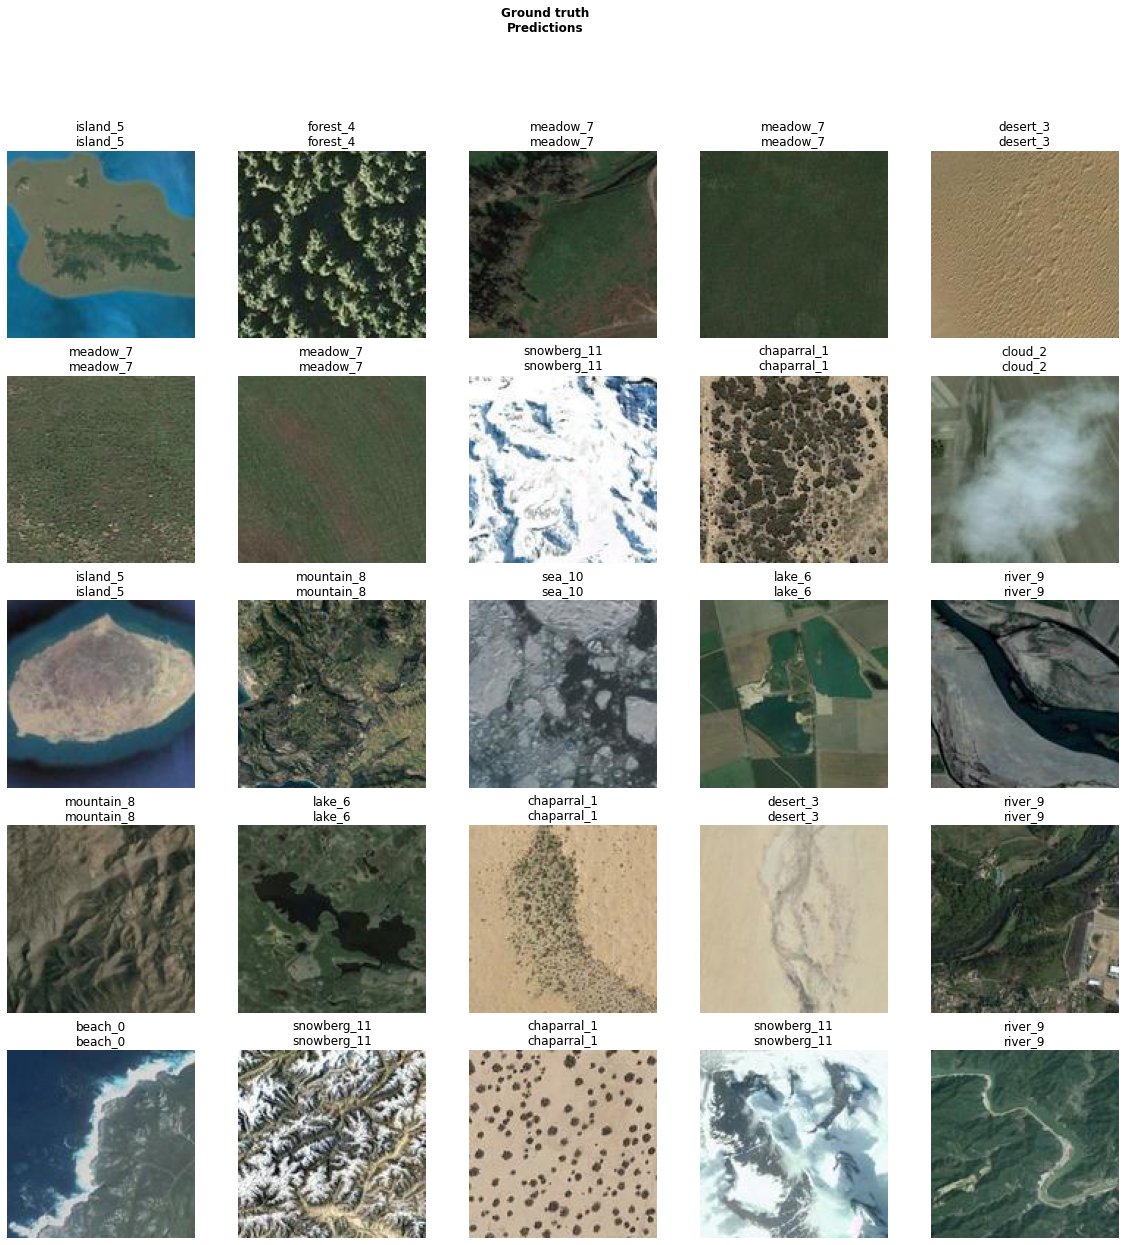

In [33]:
learner.show_results(rows=5)

In [34]:
interpreter = faiv.ClassificationInterpretation.from_learner(learner)

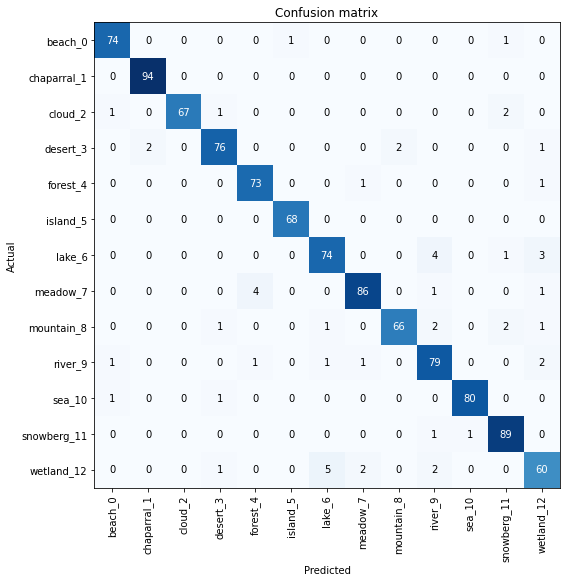

In [35]:
interpreter.plot_confusion_matrix(figsize=(8,8))

Plot the images having the highest loss, with a GradCAM overlaid as heatmap. \
We can see the input region having the most impact on the predictions.


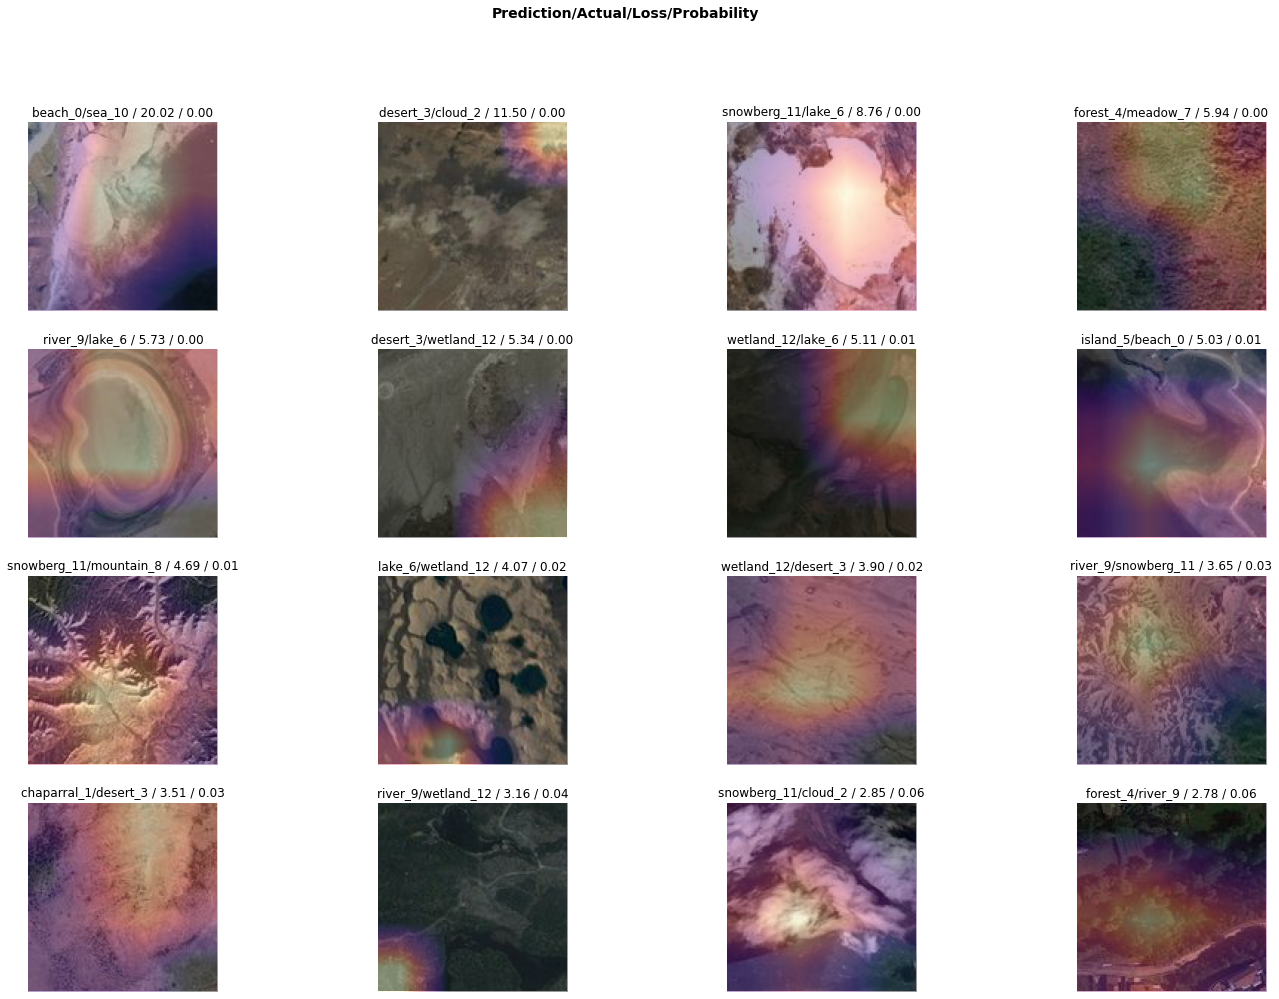

In [36]:
interpreter.plot_top_losses(16, heatmap=True, alpha=0.4, figsize=(24, 16))

In [37]:
print(os.listdir(models_dir))


learner.model_dir = models_dir
saved_model_path = learner.save('resnet18', return_path=True)
print(saved_model_path)

learner.export(models_dir.joinpath('resnet18.pkl'))

['.DS_Store', 'resnet18.pth', 'resnet18.pkl']
/Users/md_76s/Desktop/Files/starting_kit/models/resnet18.pth


In [38]:
learner.export(models_dir.joinpath('resnet18.pkl'))

In [39]:
interpreter.most_confused(min_val=3)

[('wetland_12', 'lake_6', 5),
 ('lake_6', 'river_9', 4),
 ('meadow_7', 'forest_4', 4),
 ('lake_6', 'wetland_12', 3)]

In [40]:
# check label order
print(learner.data.classes)

['beach_0', 'chaparral_1', 'cloud_2', 'desert_3', 'forest_4', 'island_5', 'lake_6', 'meadow_7', 'mountain_8', 'river_9', 'sea_10', 'snowberg_11', 'wetland_12']


In [41]:
# recover the initial order from the image name
def get_image_index(filepath):
  filename = str(filepath)
  index = int(filename[filename.rindex('-index_') + len('-index_') : filename.rindex('.')])
  return index

def sort_label(labels, dataset):
  image_index = np.vectorize(get_image_index)(dataset)
  sorted_labels = labels[np.argsort(image_index)]
  return sorted_labels

In [27]:
# load the saved model
learner = faiv.cnn_learner(databunch, faiv.models.resnet18, metrics=faiv.accuracy).load(models_dir.joinpath('resnet18'))


FileNotFoundError: [Errno 2] No such file or directory: '/Users/md_76s/Desktop/Files/starting_kit/models/resnet18.pkl.pth'

In [43]:
# recover the train predictions
def get_sorted_train_predictions(learner):
  train_labels = np.array([learner.predict(train_input[0])[1] for train_input in learner.data.train_ds])
  trainvalid_labels = np.array([learner.predict(trainvalid_input[0])[1] for trainvalid_input in learner.data.valid_ds])
  labels_unsorted = np.concatenate((train_labels, trainvalid_labels), axis=0)
  sorted_labels = sort_label(labels_unsorted, np.concatenate((learner.data.train_dl.dataset.items, learner.data.valid_dl.dataset.items), axis=0))
  return sorted_labels

In [44]:
yhat_train_faiv = get_sorted_train_predictions(learner)
print(yhat_train_faiv.shape)
print(yhat_train_faiv[:10])

(5200,)
[5 0 0 1 0 6 9 1 9 0]


In [45]:
# infer and format predictions
def get_inference_data(img_dir):
  inference_data = (faiv.ImageList.from_folder(img_dir)
        .split_none()          
        .label_empty()
        .databunch(bs=128)
        .normalize(faiv.imagenet_stats))    
  return inference_data

def predict_test(learner, test_data):
  unsorted_labels = np.array([learner.predict(train_input[0])[1] for train_input in test_data.train_ds])
  sorted_labels = sort_label(unsorted_labels, test_data.train_dl.dataset.items)

def infer(test_learner):
  probabilities, _ = test_learner.get_preds(ds_type=faiv.DatasetType.Test)
  labels = np.apply_along_axis(np.argmax, axis=1, arr=probabilities)
  sorted_labels = sort_label(labels, test_learner.data.test_dl.dataset.items)
  return sorted_labels

In [46]:
yhat_valid_faiv = infer(faiv.load_learner(models_dir, 'resnet18.pkl', test=faiv.ImageList.from_folder(image_dir.joinpath('valid'))))
yhat_test_faiv = infer(faiv.load_learner(models_dir, 'resnet18.pkl', test=faiv.ImageList.from_folder(image_dir.joinpath('test'))))

In [47]:
yhat_valid_faiv[:10]

array([10,  8,  0, 10,  9,  5, 10, 12,  4,  4])

In [48]:
yhat_test_faiv[:10]

array([5, 7, 5, 2, 6, 6, 6, 8, 8, 4])

In [49]:
print(yhat_valid_faiv.shape, yhat_test_faiv.shape, yhat_train_faiv.shape)
print(yhat_valid_faiv[:10])
print(yhat_test_faiv[:10])

(1950,) (1950,) (5200,)
[10  8  0 10  9  5 10 12  4  4]
[5 7 5 2 6 6 6 8 8 4]


#### Writing Predections

In [50]:
# m.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', yhat_train_faiv)
write(result_name + '_valid.predict', yhat_valid_faiv)
write(result_name + '_test.predict', yhat_test_faiv)

!ls $result_name*

sample_result_submission/Areal_test.predict
sample_result_submission/Areal_train.predict
sample_result_submission/Areal_valid.predict


# Scoring the result

Obviously, since it is made with sample_data, which has too few samples, results won't be really good

In [51]:
from scoring_program.libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)

Using scoring metric: accuracy


In [52]:
print(os.getcwd())

/Users/md_76s/Desktop/Files/starting_kit


In [53]:
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, yhat_train_faiv))
if len(D.data['Y_valid']) > 0 and len(D.data['Y_test']) > 0:
    print('Valid score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_valid'], yhat_valid_faiv))
    print('Test score for the', metric_name, 'metric = %5.4f' % scoring_function(D.data['Y_test'], yhat_test_faiv))

Ideal score for the accuracy metric = 1.0000
Training score for the accuracy metric = 0.9679


## Confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(Y_train, yhat_train_faiv)

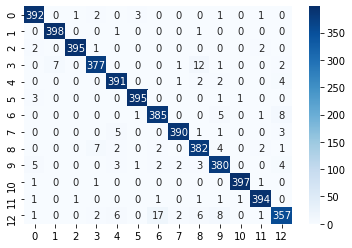

In [55]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues',)

# Submission

## Example

Example needs to have python3 installed

Test to see whether submission with ingestion program is working

In [56]:
!python3 $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

python3: can't open file '/ingestion.py': [Errno 2] No such file or directory


### Test scoring program

In [57]:
scoring_output_dir = 'scoring_output'
!python3 $score_dir/score.py $data_dir $result_dir $scoring_output_dir

python3: can't open file '/score.py': [Errno 2] No such file or directory


# Prepare the submission

In [58]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = './submissions/sample_code_submission_' + the_date + '.zip'
sample_result_submission = './submissions/sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
./submissions/sample_code_submission_20-12-30-21-05.zip
./submissions/sample_result_submission_20-12-30-21-05.zip
